In [1]:
# Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.models import Model
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize


In [3]:

# Directory structure
TRAIN_DIR = "PROCESSED_DATA/TRAINING_DATA/TRAINING_AUGMENTED_DATA"
VALID_DIR = "PROCESSED_DATA/VALIDATION_DATA/"
TEST_DIR = "PROCESSED_DATA/TEST_DATA/"

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load Data
DATAGEN = ImageDataGenerator(rescale=1./255)

def load_data(directory,shuffle_flag=True):
    generator = DATAGEN.flow_from_directory(
    directory,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',shuffle=shuffle_flag)
    return generator


TRAIN_GENERATOR = load_data(TRAIN_DIR)
VAL_GENERATOR = load_data(VALID_DIR)
TEST_GENERATOR = load_data(TEST_DIR,shuffle_flag=False)


Found 6642 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
Found 220 images belonging to 11 classes.


In [8]:
# MODEL BUILDING Functions -------------------

def build_cnn(dropout_percent=0.5):
    '''
    Param: dropout_percent - float
    Use: builds keras CNN model
    '''
    
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(dropout_percent),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    return model

def build_transfer_learning(model_name,dropout_percent=0.5):
    '''
    Param: model_name - str
    Use: updates base model using transfer learning
    '''
    
    if model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    elif model_name == 'EfficientNet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    else:
        raise ValueError("Invalid model name. Choose from 'ResNet50', 'EfficientNet', or 'VGG16'")

    # freeze the base model layers
    base_model.trainable = False  
    
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_percent)(x)
    
    output_layer = Dense(train_generator.num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    return model


def full_build_cnn(use_transfer_learning=False, transfer_model_name = 'ResNet50', lr = 0.0001,
                   metrics_lst = ['accuracy'],val_generator = VAL_GENERATOR, epoch_num = 10,
                   play_sound_flag = True,dropout_percent=0.5):
    '''
    Param: 
        - use_transfer_learning - boolean indicating if this model should use transfer learning
        - transfer_model_name - str in ['ResNet50', 'EfficientNet', 'VGG16']
        - lr - float denoting learning rate
        - metrics_lst - list of metrics to use in model compilation
        - val_generator - validation data generator from load_data function

    Use: builds, trains, and compiles cnn model
    
    Returns: 
        - model - keras model object
        - training_history - keras model training history
    '''
    
    if use_transfer_learning:
        model = build_transfer_learning(transfer_model_name,dropout_percent = dropout_percent)
        
    else:
        model = build_cnn(dropout_percent = dropout_percent)
    
    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr), loss='categorical_crossentropy', metrics = metrics_lst)
    
    # training
    training_history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs = epoch_num
    )

    if play_sound_flag == True:
        
        # Sound that plays after training model is finished
        repeat_times = 3  
        if os.name == 'posix':  # For macOS and Linux
            for _ in range(repeat_times):
                os.system('afplay /System/Library/Sounds/Glass.aiff')  # macOS
                # Linux users: os.system('aplay /path/to/sound.wav')
                
    return model, training_history


def evaluate_model(model, filename = "pest_classifier_cnn.h5"):
    '''
    Saves model to h5 file, returns test accuracy loss and test accuracy
    '''
    # evaluate on test data
    test_loss, test_acc = model.evaluate(TEST_GENERATOR)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # save to file
    model.save(filename)

    return test_loss, test_acc



# MODEL EVALUATION Functions ------

def create_classification_report(y_true, y_pred, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred: predicted class labels
        class_indices: mapping of class labels to class names.

    Function:
        generates a classification report including precision, recall, F1-score, and accuracy for each class
        outputs the report as a DataFrame for further analysis

    Returns:
        classification report as a dataframe
    '''
    report = classification_report(y_true, y_pred, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:")
    display(report_df)
    return report_df

    
def plot_confusion_matrix(y_true, y_pred, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred: predicted class labels
        class_indices: Mapping of class labels to class names

    Function:
        Plots a confusion matrix

    '''
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(cmap=plt.cm.Blues, colorbar=True)
    plt.xticks(rotation=90)
    plt.title('Confusion Matrix')
    plt.show()


def plot_loss_curves(training_history):
    '''
    Params:
        training_history: object from model.fit() training history containing metrics accuracy and loss

    Function:
        plots training and validation accuracy and loss curves to evaluate model performance over epochs

    '''
    accuracy = training_history.history.get('accuracy', [])
    val_accuracy = training_history.history.get('val_accuracy', [])
    loss = training_history.history.get('loss', [])
    val_loss = training_history.history.get('val_loss', [])
    epochs = range(len(accuracy))

    # Plot training validation accuracy curve
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_roc_curve(y_true, y_pred_probs, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred_probs: predicted probabilities for each class
        class_indices: mapping of class labels to class names

    Function:
        plots the receiver operating characteristic (ROC) curve for each class and calculates the macro-averaged
        one vs rest (OvR) ROC AUC score

    Returns:
        macro averaged one vs rest ROC AUC score
    '''

    # ROC AUC reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # ROC curve and AUC for multi-class classification
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_indices))))
    n_classes = y_true_bin.shape[1]

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "purple", "green", "gold", "deeppink", "brown", "gray", "navy"])

    for i, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_true_bin[:, i],
            y_pred_probs[:, i],
            name=f"Class {i}",
            color=color,
            ax=ax
        )

    # Macro average reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # Macro average ROC AUC score using OvR strategy
    macro_roc_auc_ovo = roc_auc_score(y_true, 
                                      y_pred_probs, 
                                      multi_class="ovr", 
                                      average="macro")
    
    # ROC AUC plot reference: https://scikit-learn.org/1.1/auto_examples/model_selection/plot_roc.html
    # Plot ROC AUC curve
    ax.plot([0, 1], [0, 1], "k--", label="Chance Level (0.5)")
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC Curve",
    )
    ax.legend(loc="lower right")
    plt.show()
    print(f"Macro-averaged One-vs-One ROC AUC score: {macro_roc_auc_ovo:.2f}")
    return macro_roc_auc_ovo

    
def evaluation_metrics(model, generator, training_history):
    '''
    Params:
        model: trained model
        generator: data generator for the evaluation set
        training_history: object from model.fit() training history containing metrics accuracy and loss

    Function:
        combines evaluation metrics (classification report, confusion matrix, training curves, and ROC curve)
        outputs key metrics: accuracy, precision, recall, and F1-score

    Returns: 
        dictionary containing:
            accuracy: model accuracy on the evaluation data
            precision: macro averaged precision score
            recall: macro averaged recall score
            f1_score: macro averaged F1 score
            classification_report_df: classification report as a dataframe

    Outputs:
        confusion matrix plot
        loss plots
        macro average ROC curve plot
        macro averaged one vs one ROC AUC score
    '''
    
    y_true = generator.classes
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    class_indices = generator.class_indices

    # Classification report
    report_df = create_classification_report(y_true, y_pred, class_indices)

    # Confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_indices)
    
    # Loss curves
    plot_loss_curves(training_history)

    # ROC AUC OvR score
    macro_roc_auc_ovo = plot_roc_curve(y_true, y_pred_probs, class_indices)

    # Get key metrics
    accuracy = round(report_df.loc["accuracy", "precision"], 3)
    precision = round(report_df.loc["macro avg", "precision"], 3)
    recall = round(report_df.loc["macro avg", "recall"], 3)
    f1_score = round(report_df.loc["macro avg", "f1-score"], 3)

    # Print key metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "classification_report_df": report_df
    }



/Users/keeganveazey/Desktop/ds_capstone/BugBot/bugbot_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


208/208 ━━━━━━━━━━━━━━━━━━━━ 69s 329ms/step - accuracy: 0.1346 - loss: 2.3704 - val_accuracy: 0.3045 - val_loss: 2.1443
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.1809 - loss: 2.2027 


Test Accuracy: 0.2182
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step 
Classification Report:


,precision,recall,f1-score,support
adult rice weevil,0.000000,0.000000,0.000000,20.000000
american house spider,0.125000,0.050000,0.071429,20.000000
bedbug,0.250000,0.200000,0.222222,20.000000
brown stink bug,0.600000,0.450000,0.514286,20.000000
carpenter ant,0.428571,0.150000,0.222222,20.000000
cellar spider,0.225806,0.350000,0.274510,20.000000
flea,0.250000,0.450000,0.321429,20.000000
house centipede,0.161290,0.250000,0.196078,20.000000
silverfish,0.000000,0.000000,0.000000,20.000000
subterranean termite,0.140000,0.350000,0.200000,20.000000


<Figure size 800x600 with 0 Axes>

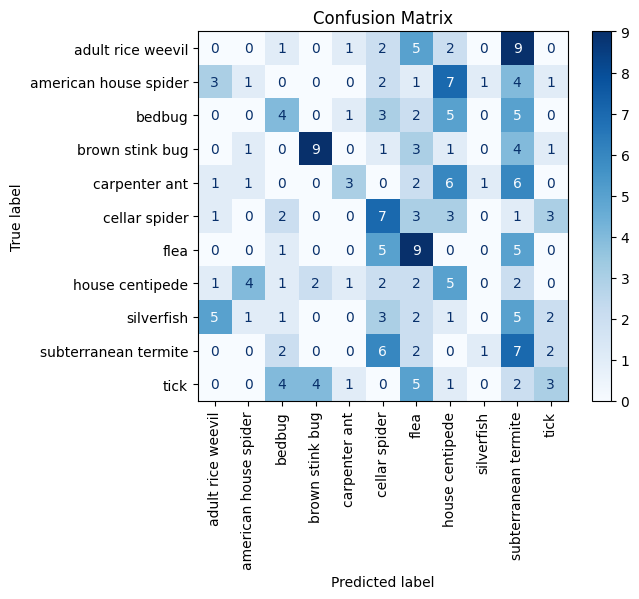

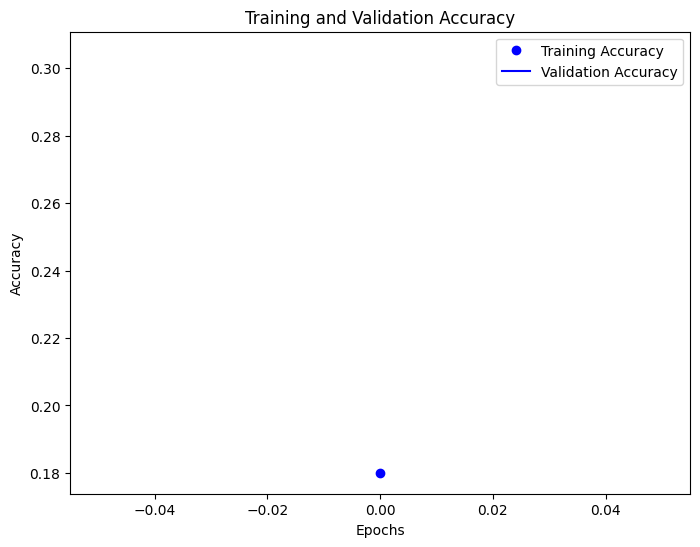

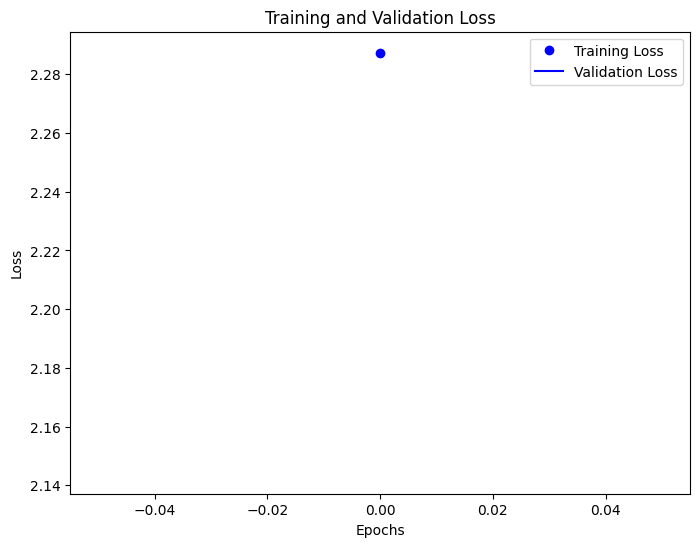

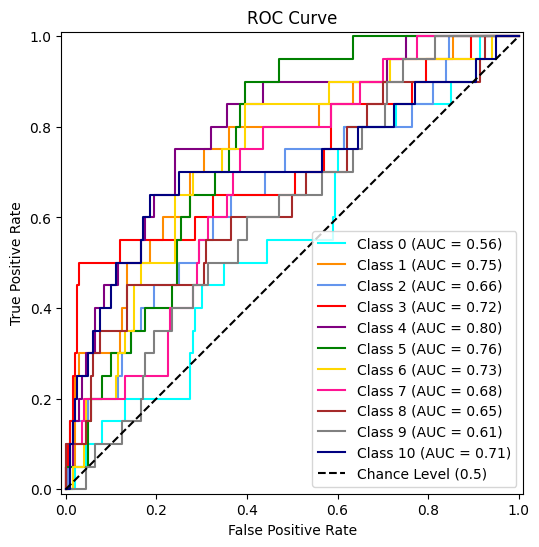

Macro-averaged One-vs-Rest ROC AUC score: 0.69
Accuracy: 0.218
Precision: 0.221
Recall: 0.218
F1 Score: 0.201


In [9]:
# CNN - BASE ONLY, NO transfer learning
basic_cnn_model, basic_training_history = full_build_cnn(epoch_num=1)
basic_test_loss, basic_test_acc = evaluate_model(basic_cnn_model)

# Run evaluation metrics on base cnn model 
basic_model_metrics = evaluation_metrics(basic_cnn_model, TEST_GENERATOR, basic_training_history)


208/208 ━━━━━━━━━━━━━━━━━━━━ 154s 733ms/step - accuracy: 0.1073 - loss: 2.8156 - val_accuracy: 0.1614 - val_loss: 2.3357
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - accuracy: 0.1933 - loss: 2.3153


Test Accuracy: 0.1364
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 561ms/step
Classification Report:


/Users/keeganveazey/Desktop/ds_capstone/BugBot/bugbot_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/keeganveazey/Desktop/ds_capstone/BugBot/bugbot_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/keeganveazey/Desktop/ds_capstone/BugBot/bugbot_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

,precision,recall,f1-score,support
adult rice weevil,0.106383,0.500000,0.175439,20.000000
american house spider,0.000000,0.000000,0.000000,20.000000
bedbug,0.000000,0.000000,0.000000,20.000000
brown stink bug,0.109375,0.350000,0.166667,20.000000
carpenter ant,0.178571,0.250000,0.208333,20.000000
cellar spider,0.222222,0.300000,0.255319,20.000000
flea,0.000000,0.000000,0.000000,20.000000
house centipede,0.000000,0.000000,0.000000,20.000000
silverfish,1.000000,0.050000,0.095238,20.000000
subterranean termite,0.000000,0.000000,0.000000,20.000000


<Figure size 800x600 with 0 Axes>

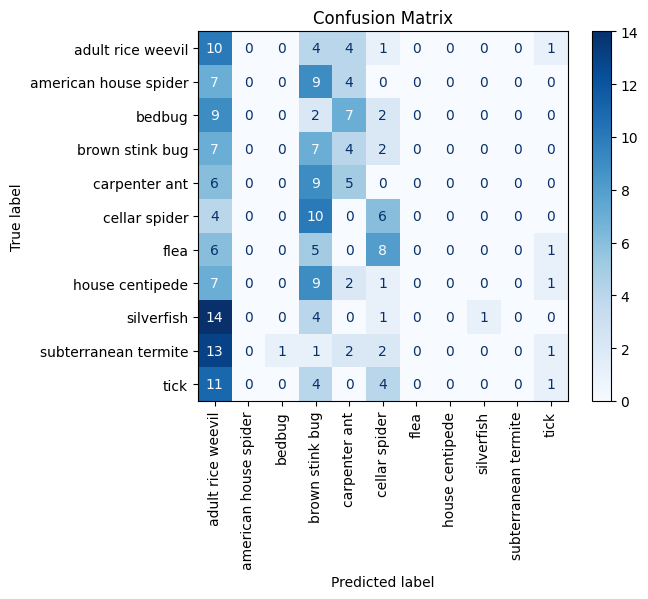

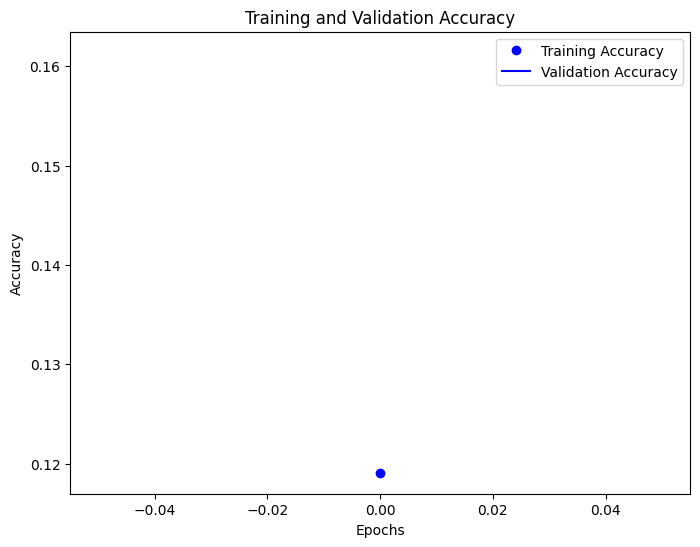

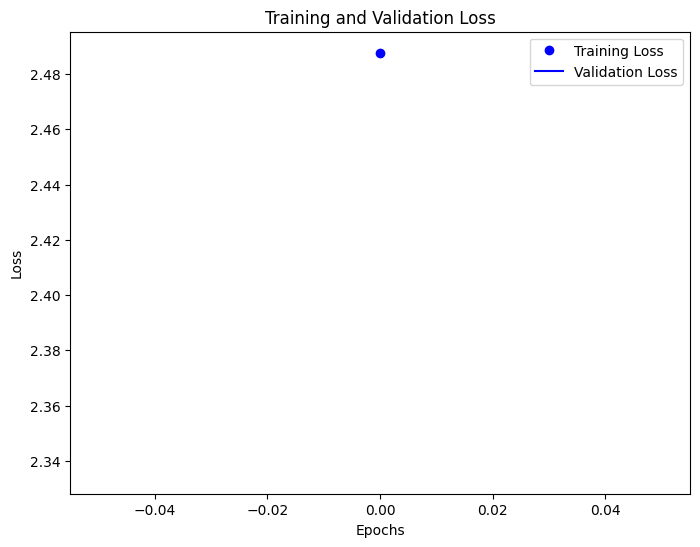

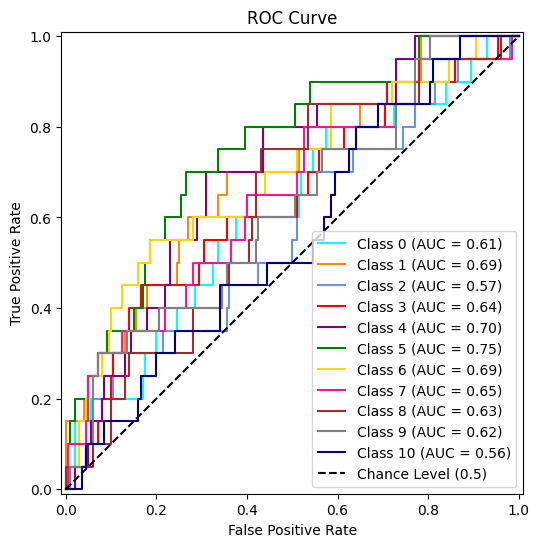

Macro-averaged One-vs-One ROC AUC score: 0.65
Accuracy: 0.136
Precision: 0.165
Recall: 0.136
F1 Score: 0.089


In [11]:
# CNN - Transfer learning with ResNet50
resnet_model,resnet_training_history = full_build_cnn(use_transfer_learning = True, transfer_model_name = "ResNet50",epoch_num=1)
resnet_test_loss, resnet_test_acc = evaluate_model(resnet_model, filename = "pest_classifier_cnn_resnet.h5")
resnet_model_metrics = evaluation_metrics(resnet_model, TEST_GENERATOR, resnet_training_history)
